# Missing Pixel Experiment face images


In [38]:
%reset -f

In [117]:
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import normalize as l2_normalize
from time import *

from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import orthogonal_mp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import random
import pickle

from PIL import Image
import imageio
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_theme()

# Utility functions

In [118]:
def normalize(image):
    image = image.astype(float)
    if image.min() != image.max():
        image -= image.min()
    
    nonzeros = np.nonzero(image)
    image[nonzeros] = image[nonzeros] / image[nonzeros].max()
    return image

def visualize_dictionary(dictionary, rows, cols, show=True, title=None):
    
    size = int(np.sqrt(dictionary.shape[0])) + 2
    img = np.zeros((rows * size, cols * size))

    for row in range(rows):
        for col in range(cols):
            atom = row * cols + col
            at = normalize(dictionary[:, atom].reshape(size - 2, size - 2))
            padded = np.pad(at, 1, mode='constant', constant_values=1)
            img[row * size:row * size + size, col * size:col * size + size] = padded

    plt.imshow(img, cmap=plt.cm.bone, interpolation='nearest')
    plt.axis('off')

    if title is not None:
        title = title if isinstance(title, str) else str(title)
        plt.title(title)

    if show:
        plt.show()
        
        
def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(1, 2,2 )
    plt.title("Original ")
    plt.imshow(reference, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")

    
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)        


# Variables

In [119]:
patch_size = (8, 8)
patch_vector_len = patch_size[0]*patch_size[1]
n_components = 441

# Creating Overcomplete DCT dictionary

(64, 441)


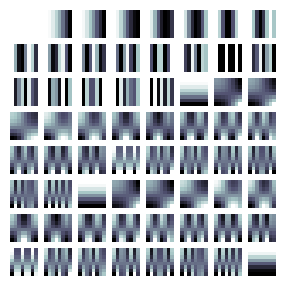

In [120]:
plt.rcParams['figure.figsize'] = [15, 5]

n_atoms = n_components
size = patch_size[0]

p = int(math.ceil(math.sqrt(n_atoms)))
dct = np.zeros((size, p))

for k in range(p):
    basis = np.cos(np.arange(size) * k * math.pi / p)
    if k > 0:
        basis = basis - np.mean(basis)

    dct[:, k] = basis

kron = np.kron(dct, dct)

for col in range(kron.shape[1]):
    norm = np.linalg.norm(kron[:, col]) or 1
    kron[:, col] /= norm
    
dct_dict = kron    


print(dct_dict.shape)
visualize_dictionary(dct_dict,8,8)

# Reading test Image and distorting 

Distorting image...
Shape of Test Image (250, 250)


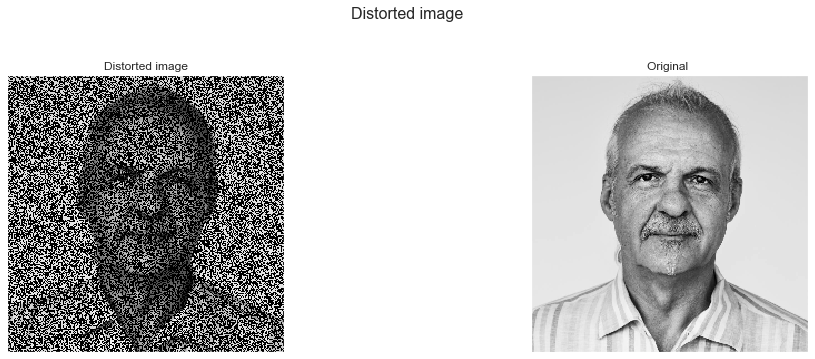

In [121]:
face = imageio.imread('original.jpg')

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.0

# downsample for higher speed
face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
face /= 4.0
height, width = face.shape

# Distort the image
print("Distorting image...")
distorted = face.copy()

#distorted += 0.075 * np.random.randn(height, width)

for _ in range(int(np.floor(height*width*0.80))):
     distorted[random.randint(0, height - 1), random.randint(0, width - 1)] = 0

        
mask = np.ones((height,width))
mask[np.argwhere(distorted==0)]=0

print("Shape of Test Image",distorted.shape)
show_with_diff(distorted, face, "Distorted image")

# Creating patches from distorted images

In [139]:
print("Extracting noisy patches... ")
t0 = time()
#data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
test_data = extract_patches_2d(distorted[:, :], patch_size)
test_data = test_data.reshape(test_data.shape[0], -1)
# intercept = np.mean(test_data, axis=0)
# test_data -= intercept
print("done in %.2fs." % (time() - t0))
print("Test Signal/ Patch sizes",test_data.shape)

Extracting noisy patches... 
done in 0.02s.
Test Signal/ Patch sizes (59049, 64)


# Creating training image patches

Extracting reference patches...
done in 0.08s.
Training Signal/ Patch sizes (138384, 64)


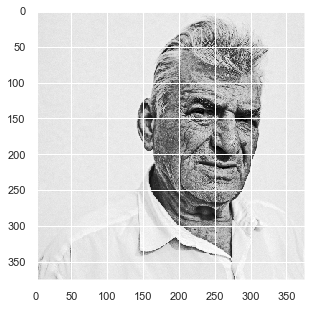

In [123]:
trainer = imageio.imread('training_image.jpg')
trainer = trainer / 255.0
DownSampleCount = 8
trainer = trainer[::DownSampleCount, ::DownSampleCount] + trainer[1::DownSampleCount, ::DownSampleCount] + trainer[::DownSampleCount, 1::DownSampleCount] + trainer[1::DownSampleCount, 1::DownSampleCount]
trainer /= 4.0

#Extract patches from the training image
print("Extracting reference patches...")
t0 = time()
train_data = extract_patches_2d(trainer[:, :], patch_size)
train_data = train_data.reshape(train_data.shape[0], -1)
train_data -= np.mean(train_data, axis=0)
train_data /= np.std(train_data, axis=0)
print("done in %.2fs." % (time() - t0))
print("Training Signal/ Patch sizes",train_data.shape)
plt.imshow(trainer, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")

# Learning dictionary MiniBatch LARS (Scikit)

Learning the dictionary...
done in 25.10s.


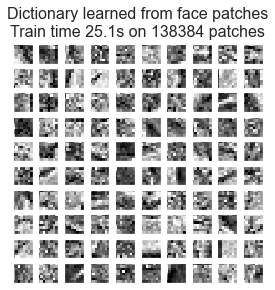

In [124]:
print("Learning the dictionary...")
t0 = time()
dico = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, n_iter=500)
V = dico.fit(train_data).components_
dt = time() - t0
print("done in %.2fs." % dt)

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(train_data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)



# SciKit dict using OMP to fill missing pixels

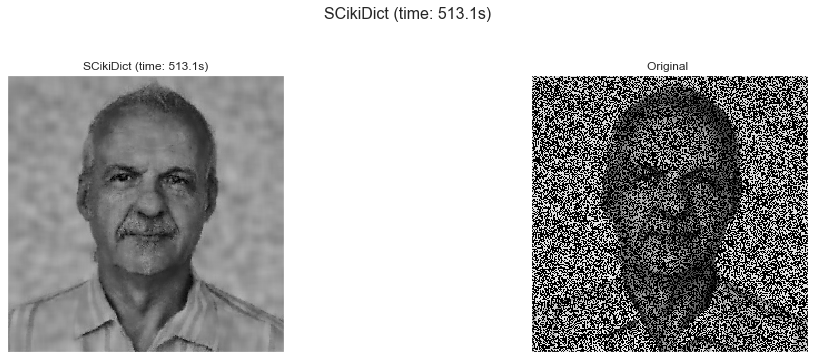

In [145]:
reconstructions = {}
title = "SCikiDict"

reconstructions[title] = face.copy()

t0 = time()
code_lars_list=[]
patch = np.empty((64,0))
for patch_num in range(len(test_data)):
    m = np.ones((patch_vector_len,1))
    test_signal = test_data[patch_num][:,np.newaxis]
    m[test_signal==0]=0
    Vm = l2_normalize(V.T*m, axis=0, norm='l2')
    code = orthogonal_mp(Vm,test_signal,tol = 0.02,precompute=True)
    code_lars_list.append(code)    
    patch_current = V.T@code[:,np.newaxis]
    patch = np.hstack((patch,patch_current))
dt = time() - t0
    
patches = patch.T
patches_Scikit = patches.reshape(len(test_data), *patch_size) 
reconstructions[title][:, :] = reconstruct_from_patches_2d(patches_Scikit, (height, width))
show_with_diff(reconstructions[title], distorted, title + " (time: %.1fs)" % dt)
plt.show()  

# OverComplete DCT dict using OMP to fill missing pixels

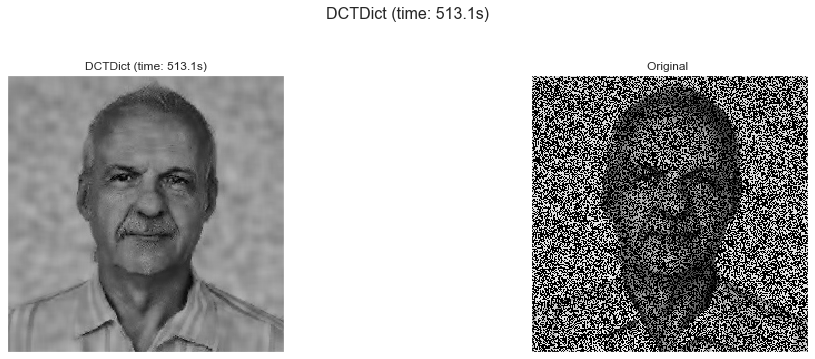

In [146]:
reconstructions = {}
title = "DCTDict"

reconstructions[title] = face.copy()
D = dct_dict
code_dct_list = []
patch = np.empty((64,0))
for patch_num in range(len(test_data)):
    m = np.ones((patch_vector_len,1))
    test_signal = test_data[patch_num][:,np.newaxis]
    m[test_signal==0]=0
    Dm = l2_normalize(D*m, axis=0, norm='l2')
    code = orthogonal_mp(Dm,test_signal,tol = 0.02,precompute=True)
    code_dct_list.append(code)
    patch_current = D@code[:,np.newaxis]
    patch = np.hstack((patch,patch_current))

    
patches = patch.T
patches_dctdict = patches.reshape(len(test_data), *patch_size) 
reconstructions[title][:, :] = reconstruct_from_patches_2d(patches_dctdict, (height, width))
show_with_diff(reconstructions[title], distorted, title + " (time: %.1fs)" % dt)
plt.show() 

In [177]:
# Pretrained KSVD Dictionary using OMP to fill missing pixels

In [129]:
# file_path = "100k_natural_image_patches_Elad__dl__64__256__.pkl"
# data = pickle.load(open(file_path, "rb"))

# reconstructions = {}
# title = "KSVD-pretrained"

# reconstructions[title] = face.copy()
# D = dct_dict

# patch = np.empty((64,0))
# for patch_num in range(len(test_data)):
#     m = np.ones((patch_vector_len,1))
#     test_signal = test_data[patch_num][:,np.newaxis]
#     m[test_signal==0]=0
#     Dm = l2_normalize(D*m, axis=0, norm='l2')
#     code = orthogonal_mp(Dm,test_signal,tol = 0.02,precompute=True)
#     patch_current = D@code[:,np.newaxis]
#     patch = np.hstack((patch,patch_current))

    
# patches = patch.T
# patches = patches.reshape(len(test_data), *patch_size) 
# reconstructions[title][:, :] = reconstruct_from_patches_2d(patches, (height, width))
# show_with_diff(reconstructions[title], distorted, title + " (time: %.1fs)" % dt)
# plt.show() 

# Creating non overlapping training images

Extracting reference patches...
done in 0.66s.
Training Signal/ Patch sizes (8836, 64)


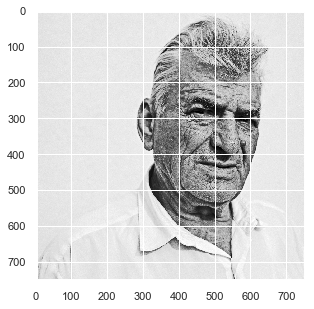

In [130]:
trainer = imageio.imread('training_image.jpg')
trainer = trainer / 255.0
DownSampleCount = 4
trainer = trainer[::DownSampleCount, ::DownSampleCount] + trainer[1::DownSampleCount, ::DownSampleCount] + trainer[::DownSampleCount, 1::DownSampleCount] + trainer[1::DownSampleCount, 1::DownSampleCount]
trainer /= 4.0

#Extract patches from the training image
print("Extracting reference patches...")
t0 = time()

train_data = np.array([trainer[8*i:(i+1)*8,8*j:(j+1)*8].flatten() for i in range(trainer.shape[0]//8) for j in range(trainer.shape[0]//8)])
train_data -= np.mean(train_data, axis=0)
train_data /= np.std(train_data, axis=0)
print("done in %.2fs." % (time() - t0))
print("Training Signal/ Patch sizes",train_data.shape)
plt.imshow(trainer, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")

# KSVD Training

In [131]:
if(os.path.exists('KSVD_DICT.pickle')):
    print("Dictionary is learned")
    with open('KSVD_DICT.pickle', 'rb') as handle:
        b = pickle.load(handle) 
    D1 = b["KSVD_DICT"]
else:
    n = patch_vector_len
    K = n_components
    Y = train_data.T
    N = Y.shape[1]

    # initial dictionary
    D1 = l2_normalize(np.random.rand(n, K), axis=0, norm='l2')

    for J in range(10):
        t0 = time()
        ##### Sparse coding Stage ############
        X = orthogonal_mp(D1,Y,n_nonzero_coefs = 10,precompute=True)
        ωk = np.argwhere(X.T[k]!=0)
        dt2 = time()-t0
        print(f"Time taken in Sparse code OMP at iteration {J} = {dt2}")

        #######################################

        ######  Dictionary Update Stage ######    
        for k in range(K):
            t1 = time()
            Ek = np.zeros((n,N))
            for j in range(K):
                if(j!=k):
                    Ek = Ek+D1[:,[j]]@X[[j],:]

            Ωk = np.ones((n,N))
            Ωk[:,ωk]=0
            Ekr = Ek*Ωk

            U,Δ,V = np.linalg.svd(Ekr)
            D1[:,0] = U[:,0]
            X[k,:] = Δ[0]*V[:,0]
            dt1 = time()-t1
            print(f"Time taken in internal loop dictionary update for column {k} = {dt1}")
        #######################################


        dt = time()-t0
        print("############################")
        print(f"Time Taken in interation {J+1} = {dt}")
    a = {"KSVD_DICT":D1}
    with open('KSVD_DICT.pickle', 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

Dictionary is learned


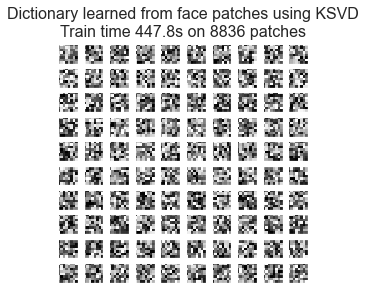

In [133]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(D1.T[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches using KSVD\n"
    + "Train time %.1fs on %d patches" % (dt, len(train_data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


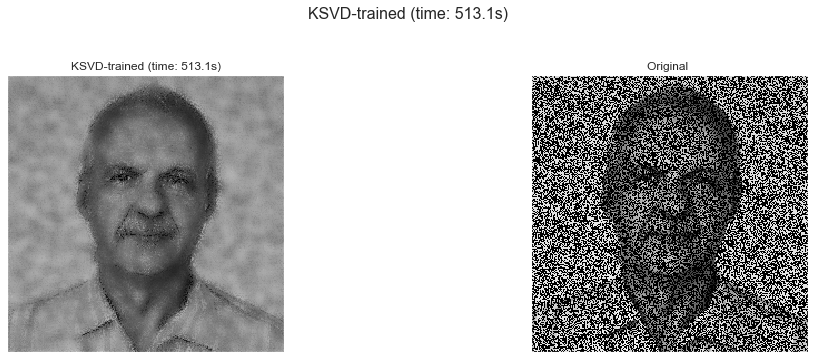

In [167]:
reconstructions = {}
title = "KSVD-trained"

reconstructions[title] = face.copy()

code_ksvd_list = []
patch = np.empty((64,0))
for patch_num in range(len(test_data)):
    m = np.ones((patch_vector_len,1))
    test_signal = test_data[patch_num][:,np.newaxis]
    m[test_signal==0]=0
    D1m = l2_normalize(D1*m, axis=0, norm='l2')
    code = orthogonal_mp(D1m,test_signal,tol = 0.02,precompute=True)
    code_ksvd_list.append(code)
    patch_current = D1@code[:,np.newaxis]
    patch = np.hstack((patch,patch_current))

    
patches = patch.T
patches = patches.reshape(len(test_data), *patch_size) 
reconstructions[title][:, :] = reconstruct_from_patches_2d(patches, (height, width))
show_with_diff(reconstructions[title], distorted, title + " (time: %.1fs)" % dt)
plt.show() 

In [168]:
####check sparsity power here
# code_ksvd_list = np.array(code_ksvd_list)
# code_dct_list = np.array(code_dct_list)
# code_lars_list = np.array(code_lars_list)

# #patches
# #patches_dctdict
# #patches_Scikit